# Results, section 3:

In [1]:
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec/code/func/')
from proj_environment import set_proj_env
from func import run_corr, get_fdr_p, get_cmap, perc_dev, get_fdr_p_df

In [3]:
train_test_str = 'squeakycleanExclude' # 'squeakycleanExclude' 'trte_psychopathology'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 400
primary_covariate = 'ageAtScan1_Years'
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(train_test_str = train_test_str, exclude_str = exclude_str,
                                                                            parc_str = parc_str, parc_scale = parc_scale)

In [4]:
os.environ['NORMATIVEDIR']

'/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec/analysis/normative/t1Exclude/squeakycleanExclude/schaefer_400_streamlineCount/ageAtScan1_Years+sex_adj'

In [5]:
metrics = ('ct', 'str', 'ac', 'mc')
phenos = ('Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear')

## Load data pre-nispat data

In [6]:
# Train
df_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'train.csv'))
df_train.set_index(['bblid', 'scanid'], inplace = True); print(df_train.shape)
df_node_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_train.csv'))
df_node_train.set_index(['bblid', 'scanid'], inplace = True)

# Test
df = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'test.csv'))
df.set_index(['bblid', 'scanid'], inplace = True); print(df.shape)
df_node = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_test.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)

(317, 21)
(783, 21)


## Age effects

In [7]:
# age effect on training set
df_age_effect = run_corr(df_train[primary_covariate], df_node_train, typ = 'spearmanr'); df_age_effect['p_fdr'] = get_fdr_p(df_age_effect['p'])
if parc_str == 'lausanne':
    df_age_effect.drop(my_list, axis = 0, inplace = True)
age_alpha = 0.05
age_filter = df_age_effect['p_fdr'].values < age_alpha

In [8]:
age_filter.sum()

1012

## Load nispat outputs

In [9]:
# Forward model
synth_cov_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'forward/synth_cov_test.txt'),
                             delim_whitespace = True, names=[primary_covariate, 'sex_adj'])

yhat_forward = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'forward/yhat.txt'), delimiter = ' ').transpose()
df_yhat_forward = pd.DataFrame(data = yhat_forward, index = synth_cov_test.index, columns = df_node.columns)

In [10]:
smse = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'smse.txt'), delimiter = ' ').transpose()
df_smse = pd.DataFrame(data = smse, index = df_node.columns)

z = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'Z.txt'), delimiter = ' ').transpose()
df_z = pd.DataFrame(data = z, index = df_node.index, columns = df_node.columns)

In [11]:
smse_thresh = 1
smse_filter = df_smse.values < smse_thresh
smse_filter = smse_filter.reshape(-1)

In [12]:
smse_filter.sum()

1023

In [13]:
region_filter = np.logical_and(age_filter,smse_filter)
region_filter.sum()

841

### The interpretation of the z-deviations varies as a function of the age-effect from which the normative model is primarily derived.
### For instance, if the normative model predicts a _decrease_ in y with age, then _positive deviations_ may be interpreted as a **_delay_** in this maturational reduction, wheras _negative deviations_ may be interpreted as an _advancement_ in this maturational reduction.
### However, if the normative model predicts an _increase_ in y with age, then the interpretation of the deviations is reversed. That is:
#### IF predicted change = negative: _positive deviations_ = **_delay_** || _negative deviations_ = **_advance_**
#### IF predicted change = positive: _positive deviations_ = **_advance_** || _negative deviations_ = **_delay_**

In [14]:
# at each roi, the differences between first and last age point in the synthetic data
# for each node/metric, a negative value means that the nm predicted an overall decrease in y with age (i.e, a negative function),
# while a positive values means that the nm predicted an overall increase in y with age (i.e., a positive function)
df_yhat_tmp1 = df_yhat_forward[synth_cov_test['sex_adj'] == 0].iloc[-1,:] - df_yhat_forward[synth_cov_test['sex_adj'] == 0].iloc[0,:]
df_yhat_tmp2 = df_yhat_forward[synth_cov_test['sex_adj'] == 1].iloc[-1,:] - df_yhat_forward[synth_cov_test['sex_adj'] == 1].iloc[0,:]
df_yhat_diff = pd.concat((df_yhat_tmp1, df_yhat_tmp2), axis = 1)

# boolean that designates which regions carry with positive predicted change.
nm_is_pos = df_yhat_diff[0] > 0

# flipping the z-stats in these regions has the effect of standardising their interpration across the brain to be inline
# with the negative predicted change statement above
df_z.loc[:,nm_is_pos] = df_z.loc[:,nm_is_pos] * -1

## Get pheno-nispat relationships

In [15]:
df_pheno_z = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'df_corr_pheno_z.csv'))
df_pheno_z.set_index(['pheno','node'], inplace = True)

In [16]:
print(str(np.sum(df_pheno_z['sig_age_smse'])) + ' significant effects (fdr)')

244 significant effects (fdr)


# Plots

In [17]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = get_cmap('pair')

phenos = ('Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear')
phenos_label_short = ('Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear')
phenos_label = ('Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)','Anxious-Misery','Externalizing','Fear')
metrics = ('ct', 'str', 'ac', 'mc')
metrics_label_short = ('Thickness', 'Strength', 'Ave. ctrb.', 'Mod. ctrb.')
metrics_label = ('Thickness', 'Strength', 'Average controllability', 'Modal controllability')

print(phenos)
print(metrics)

metrics_labels = list()
for metric in metrics:
    tmp_labels = [metric + '_' + str(i) for i in range(num_parcels)]
    metrics_labels = metrics_labels + tmp_labels

('Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg', 'AnxiousMisery', 'Externalizing', 'Fear')
('ct', 'str', 'ac', 'mc')


### Calculate node summary metrics

In [18]:
z_thr = 2.6    
# percent of supra-threshold (cf. Wolfers et al. JAMA Psych)
node_z_perc_p = perc_dev(df_z.transpose(), thr = z_thr, sign = 'pos')
node_z_perc_n = perc_dev(df_z.transpose(), thr = z_thr, sign = 'neg')

In [19]:
for metric in metrics:
    roi_data = node_z_perc_p[region_filter].filter(regex = metric)
    print('max +ve % for ' + metric + ': ' + str(np.round(roi_data.max(),2)))
    roi_data = node_z_perc_n[region_filter].filter(regex = metric)
    print('max -ve % for ' + metric + ': ' + str(np.round(roi_data.max(),2)))
    print()

max +ve % for ct: 1.28
max -ve % for ct: 0.77

max +ve % for str: 3.45
max -ve % for str: 3.32

max +ve % for ac: 7.66
max -ve % for ac: 6.13

max +ve % for mc: 8.17
max -ve % for mc: 0.26



In [20]:
pos_counts = pd.DataFrame(index = metrics, columns = phenos[1:])
neg_counts = pd.DataFrame(index = metrics, columns = phenos[1:])
stat_ttest = pd.DataFrame(index = metrics, columns = phenos[1:])
stat_ttest_p = pd.DataFrame(index = metrics, columns = phenos[1:])
which_ttest = pd.DataFrame(index = metrics, columns = phenos[1:])


for pheno in phenos[1:]:
    for metric in metrics:
#         pheno_bol = df_pheno_z.loc[pheno,'sig_age'].filter(regex = metric)
        pheno_bol = df_pheno_z.loc[pheno,'sig_age_smse'].filter(regex = metric)
        if pheno_bol.sum() > 1:
            x = node_z_perc_p.filter(regex = metric)[pheno_bol]
            y = node_z_perc_n.filter(regex = metric)[pheno_bol]

            if np.mean(x) == 0 or np.mean(y) == 0:
                if np.var(x) == 0 or np.mean(x) == 0:
                    stat_ttest.loc[metric,pheno] = sp.stats.ttest_1samp(y, popmean = 0)[0]
                    stat_ttest_p.loc[metric,pheno] = sp.stats.ttest_1samp(y, popmean = 0)[1]
                    which_ttest.loc[metric,pheno] = 'sinT'
                elif np.var(y) == 0 or np.mean(y) == 0:
                    stat_ttest.loc[metric,pheno] = sp.stats.ttest_1samp(x, popmean = 0)[0]
                    stat_ttest_p.loc[metric,pheno] = sp.stats.ttest_1samp(x, popmean = 0)[1]
                    which_ttest.loc[metric,pheno] = 'sinT'
            else:   
                stat_ttest.loc[metric,pheno] = sp.stats.ttest_rel(x,y)[0]
                stat_ttest_p.loc[metric,pheno] = sp.stats.ttest_rel(x,y)[1]
                which_ttest.loc[metric,pheno] = 'repT'

            pos_counts.loc[metric,pheno] = x.mean()
            neg_counts.loc[metric,pheno] = y.mean()
            
stat_ttest_p_fdr = get_fdr_p_df(stat_ttest_p)

In [21]:
which_ttest

,Psychosis_Positive,Psychosis_NegativeDisorg,AnxiousMisery,Externalizing,Fear
ct,repT,repT,repT,repT,repT
str,NaN,NaN,NaN,sinT,repT
ac,repT,NaN,NaN,sinT,sinT
mc,sinT,sinT,sinT,repT,repT


In [22]:
pos_counts > neg_counts

,Psychosis_Positive,Psychosis_NegativeDisorg,AnxiousMisery,Externalizing,Fear
ct,True,True,True,True,True
str,False,False,False,True,False
ac,True,False,False,True,True
mc,True,True,True,True,True


In [23]:
stat_ttest[stat_ttest_p_fdr < 0.05]

,Psychosis_Positive,Psychosis_NegativeDisorg,AnxiousMisery,Externalizing,Fear
ct,NaN,2.74174,2.96154,4.09236,4.68432
str,NaN,NaN,NaN,NaN,NaN
ac,NaN,NaN,NaN,5.20176,13.8444
mc,7.61472,6.30971,6.11884,9.32182,11.5222


Figure 5

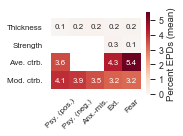

In [24]:
f, ax = plt.subplots()
f.set_figwidth(2)
f.set_figheight(1.5)
ax = sns.heatmap(pos_counts.astype(float), center = 0, vmin = 0, vmax = 5.5, annot = True, cmap = 'RdBu_r', cbar_kws={'label': 'Percent EPDs (mean)', 'shrink':1}, square = True, fmt='.1f', annot_kws={"size": 8})
ax.set_xticklabels(phenos_label_short[1:], rotation = 45, fontsize = 8)
ax.set_yticklabels(metrics_label_short, rotation = 0, fontsize = 8)
ax.set_ylabel('')
f.savefig('epd_count.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

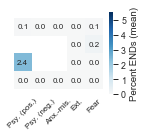

In [25]:
f, ax = plt.subplots()
f.set_figwidth(2)
f.set_figheight(1.5)
ax = sns.heatmap(neg_counts.astype(float), center = 0, vmin = 0, vmax = 5.5, annot = True, cmap = 'RdBu', cbar_kws={'label': 'Percent ENDs (mean)', 'shrink':1}, square = True, fmt='.1f', annot_kws={"size": 8})
ax.set_xticklabels(phenos_label_short[1:], rotation = 45, fontsize = 8)
ax.set_yticklabels('', rotation = 0, fontsize = 8)
ax.set_ylabel('')
f.savefig('end_count.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

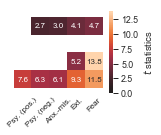

In [26]:
f, ax = plt.subplots()
f.set_figwidth(2)
f.set_figheight(1.5)
ax = sns.heatmap(stat_ttest[stat_ttest_p_fdr < 0.05].astype(float), center = 0, vmin = 0, annot = True, cbar_kws={'label': '$\it{t}$ statistics', 'shrink':1}, square = True, fmt='.1f', annot_kws={"size": 8})
ax.set_xticklabels(phenos_label_short[1:], rotation = 45, fontsize = 8)
ax.set_yticklabels('', rotation = 0, fontsize = 8)
ax.set_ylabel('')
f.savefig('epd-vs-end_ttest.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## Overlap between individuals

### Calculate subject summary metrics

In [27]:
# percent of supra-threshold (cf. Wolfers et al. JAMA Psych)
for metric in metrics:
    # percent of supra-threshold (cf. Wolfers et al. JAMA Psych)
    df[metric + '_z_perc-p'] = perc_dev(df_z.filter(regex = metric), thr = z_thr, sign = 'pos')
    df[metric + '_z_perc-n'] = perc_dev(df_z.filter(regex = metric), thr = z_thr, sign = 'neg')

In [28]:
pos_bol = df['ct_z_perc-p'] > 0 # vectors of people with non-zero 0 percentages extreme positive deviations
neg_bol = df['ct_z_perc-n'] > 0 # vectors of people with non-zero 0 percentages extreme negative deviations
sp.spatial.distance.jaccard(pos_bol, neg_bol)

0.990521327014218

In [29]:
pos_bol = df['str_z_perc-p'] > 0 # vectors of people with non-zero 0 percentages extreme positive deviations
neg_bol = df['str_z_perc-n'] > 0 # vectors of people with non-zero 0 percentages extreme negative deviations
sp.spatial.distance.jaccard(pos_bol, neg_bol)

0.7612359550561798

In [30]:
pos_bol = df['ac_z_perc-p'] > 0 # vectors of people with non-zero 0 percentages extreme positive deviations
neg_bol = df['ac_z_perc-n'] > 0 # vectors of people with non-zero 0 percentages extreme negative deviations
sp.spatial.distance.jaccard(pos_bol, neg_bol)

0.2559366754617414

In [31]:
pos_bol = df['mc_z_perc-p'] > 0 # vectors of people with non-zero 0 percentages extreme positive deviations
neg_bol = df['mc_z_perc-n'] > 0 # vectors of people with non-zero 0 percentages extreme negative deviations
sp.spatial.distance.jaccard(pos_bol, neg_bol)

0.3731543624161074

## Brain plots nispat

In [32]:
import matplotlib.image as mpimg
from brain_plot_func import roi_to_vtx, brain_plot

In [33]:
if parc_str == 'schaefer':
    subject_id = 'fsaverage'
elif parc_str == 'lausanne':
    subject_id = 'lausanne125'

In [34]:
%pylab qt

Populating the interactive namespace from numpy and matplotlib


/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'get_cmap']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Brain plots - overlap maps

In [35]:
for metric in metrics:
    cut_pos = node_z_perc_p.filter(regex = metric).mean()
    cut_neg = node_z_perc_n.filter(regex = metric).mean()
    
    for hemi in ('lh', 'rh'):
        for i in range(2):

            if i == 0:
                fig_str = hemi + '_' + metric + '_z_perc_p'
                roi_data = node_z_perc_p.filter(regex = metric).values
            elif i == 1:
                fig_str = hemi + '_' + metric + '_z_perc_n'
                roi_data = node_z_perc_n.filter(regex = metric).values

            if subject_id == 'lausanne125':
                parc_file = os.path.join('/Applications/freesurfer/subjects/', subject_id, 'label', hemi + '.myaparc_' + str(parc_scale) + '.annot')
            elif subject_id == 'fsaverage':
                parc_file = os.path.join('/Users/lindenmp/Dropbox/Work/ResProjects/NeuroDev_NetworkControl/figs/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                         hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')

            # Threshold
            roi_data[roi_data == 0] = -1000

            if np.var(roi_data) > 0:
                # project subject's data to vertices
                if subject_id == 'lausanne125' and metric == 'ct':
                    brain_plot(roi_data, parcel_names[parcel_loc == 1], parc_file, fig_str, subject_id = subject_id, hemi = hemi, color = 'hot')
                else:
                    brain_plot(roi_data, parcel_names, parc_file, fig_str, subject_id = subject_id, hemi = hemi, color = 'hot')
            else:
                print('Nothing significant')

colormap sequential: [0.00e+00, 5.75e-01, 1.15e+00] (opaque)
colormap sequential: [0.00e+00, 5.75e-01, 1.15e+00] (opaque)
colormap sequential: [0.00e+00, 3.83e-01, 7.66e-01] (opaque)
colormap sequential: [0.00e+00, 3.83e-01, 7.66e-01] (opaque)
colormap sequential: [0.00e+00, 6.39e-01, 1.28e+00] (opaque)
colormap sequential: [0.00e+00, 6.39e-01, 1.28e+00] (opaque)
colormap sequential: [0.00e+00, 3.19e-01, 6.39e-01] (opaque)
colormap sequential: [0.00e+00, 3.19e-01, 6.39e-01] (opaque)
colormap sequential: [0.00e+00, 2.11e+00, 4.21e+00] (opaque)
colormap sequential: [0.00e+00, 2.11e+00, 4.21e+00] (opaque)
colormap sequential: [0.00e+00, 1.66e+00, 3.32e+00] (opaque)
colormap sequential: [0.00e+00, 1.66e+00, 3.32e+00] (opaque)
colormap sequential: [0.00e+00, 2.49e+00, 4.98e+00] (opaque)
colormap sequential: [0.00e+00, 2.49e+00, 4.98e+00] (opaque)
colormap sequential: [0.00e+00, 1.72e+00, 3.45e+00] (opaque)
colormap sequential: [0.00e+00, 1.72e+00, 3.45e+00] (opaque)
colormap sequential: [0.

In [36]:
%matplotlib inline

Figure 4

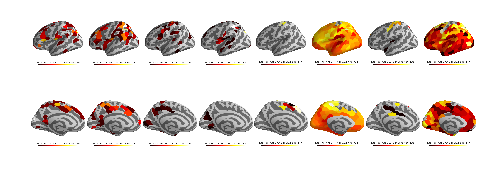

In [37]:
f, axes = plt.subplots(2, 8)
f.set_figwidth(8)
f.set_figheight(3)
plt.subplots_adjust(wspace=0, hspace=0)

# column 0:
fig_str = 'lh_ct_z_perc_n.png'
try:
#     axes[0,0].set_title('Thickness (END)')
    image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
except FileNotFoundError: axes[0,0].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
except FileNotFoundError: axes[1,0].axis('off')
    
# column 1:
fig_str = 'lh_ct_z_perc_p.png'
try:
#     axes[0,1].set_title('Thickness (EPD)')
    image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
except FileNotFoundError: axes[0,1].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
except FileNotFoundError: axes[1,1].axis('off')
    
# column 2:
fig_str = 'lh_str_z_perc_n.png'
try:
#     axes[0,2].set_title('Strength (END)')
    image = mpimg.imread('lat_' + fig_str); axes[0,2].imshow(image); axes[0,2].axis('off')
except FileNotFoundError: axes[0,2].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,2].imshow(image); axes[1,2].axis('off')
except FileNotFoundError: axes[1,2].axis('off')
    
# column 3:
fig_str = 'lh_str_z_perc_p.png'
try:
#     axes[0,3].set_title('Strength (EPD)')
    image = mpimg.imread('lat_' + fig_str); axes[0,3].imshow(image); axes[0,3].axis('off')
except FileNotFoundError: axes[0,3].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,3].imshow(image); axes[1,3].axis('off')
except FileNotFoundError: axes[1,3].axis('off')
    
# column 4:
fig_str = 'lh_ac_z_perc_n.png'
try:
#     axes[0,4].set_title('Ave. ctrb. (END)')
    image = mpimg.imread('lat_' + fig_str); axes[0,4].imshow(image); axes[0,4].axis('off')
except FileNotFoundError: axes[0,4].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,4].imshow(image); axes[1,4].axis('off')
except FileNotFoundError: axes[1,4].axis('off')
    
# column 5:
fig_str = 'lh_ac_z_perc_p.png'
try:
#     axes[0,5].set_title('Ave. ctrb. (EPD)')
    image = mpimg.imread('lat_' + fig_str); axes[0,5].imshow(image); axes[0,5].axis('off')
except FileNotFoundError: axes[0,5].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,5].imshow(image); axes[1,5].axis('off')
except FileNotFoundError: axes[1,5].axis('off')
    
# column 6:
fig_str = 'lh_mc_z_perc_n.png'
try:
#     axes[0,6].set_title('Mod. ctrb. (END)')
    image = mpimg.imread('lat_' + fig_str); axes[0,6].imshow(image); axes[0,6].axis('off')
except FileNotFoundError: axes[0,6].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,6].imshow(image); axes[1,6].axis('off')
except FileNotFoundError: axes[1,6].axis('off')
    
# column 7:
fig_str = 'lh_mc_z_perc_p.png'
try:
#     axes[0,7].set_title('Mod. ctrb. (EPD)')
    image = mpimg.imread('lat_' + fig_str); axes[0,7].imshow(image); axes[0,7].axis('off')
except FileNotFoundError: axes[0,7].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,7].imshow(image); axes[1,7].axis('off')
except FileNotFoundError: axes[1,7].axis('off')

plt.show()
# f.savefig('brain_plot_tiled_perc_pn.png', dpi = 600, bbox_inches = 'tight', pad_inches = 0)
f.savefig('brain_plot_tiled_perc_pn.svg', dpi = 1200, bbox_inches = 'tight', pad_inches = 0)